# ViT
- (What) Applying ViT for Age Classification
- (Why) Age informations are quite lack so that need another approach
- Outline
    - Adam / SGD
    - StepLR Scheduler / OneCycle
    - Multi Head Attention 8

In [1]:
# !pip install -r requirements.txt

## Load Packages

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as T
import numpy as np
import os
import copy
from cv2 import cv2
import matplotlib.pyplot as plt

from torchvision.transforms import Compose, Resize, ToTensor
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.optim import lr_scheduler
from torch import Tensor
from torchsummary import summary
from tqdm import tqdm

# custom module
from new.new_dataset import CustomDataset
from new.new_utils import is_val_loss_decreasing, check_image, check_loader, get_transformer
from new.new_model import EnsembleModel, MaskModel
from new.new_inference import test_prediction
from new.new_dataset import CustomDataset, MaskDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.long

# einops for preprocessing images to fit into ViT
from einops import rearrange, repeat, reduce
from einops.layers.torch import Rearrange, Reduce

## Load Dataset

In [15]:
root = '../input/data'

transform = get_transformer(False)
train_ds = CustomDataset(root, transform['origin'], category='age')
test_ds = MaskDataset(root, transform['origin'], train=False)

torch.Size([1, 3, 224, 224])


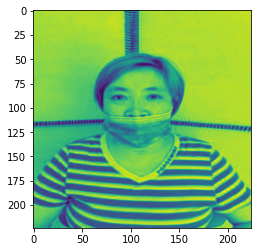

In [22]:
# check image
x = train_ds[5][0]
plt.imshow(x[0])
x = x.unsqueeze(0)
print(x.shape)

## Image Embedding

In [23]:
# patch embedding => divide into P x P size images
class image_embedding(nn.Module):
    
    def __init__(self, in_channels: int=3, img_size: int=224, patch_size: int=16, emb_dim: int=16 * 16 * 3):
        super().__init__()
        self.rearrange = Rearrange('b c (num_w p1) (num_h p2) -> b (num_w num_h) (p1 p2 c) ', p1=patch_size, p2=patch_size)
        self.linear = nn.Linear(in_channels * patch_size * patch_size, emb_dim) # output dim 16

        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_dim))           # class token with 3D array (init)
        n_patches = img_size * img_size // patch_size ** 2
        self.positions = nn.Parameter(torch.randn(n_patches + 1, emb_dim))  # position info with 2D array (init)

    def forward(self, x):
        batch, channel, width, height = x.shape

        x = self.rearrange(x) # flatten patches
        x = self.linear(x)    # embed patches

        c = repeat(self.cls_token, '() n d -> b n d', b=batch)
        x = torch.cat([c, x], dim=1) # output dim 16
        x += self.positions          # broadcasting summation
        return x

# original => 28 x 28 / embedding => 4 x 4 patch
emb = image_embedding(3, 224, 16, 16 * 16 * 3)(x)
emb.shape

torch.Size([1, 197, 768])

## MHA

In [27]:
class multi_head_attention(nn.Module):
    
    def __init__(self, emb_dim: int = 16*16*3, num_heads: int = 8, dropout_ratio: float = 0.2, verbose = False, **kwargs):
        super().__init__()
        self.v = verbose

        self.emb_dim = emb_dim 
        self.num_heads = num_heads 
        self.scaling = (self.emb_dim // num_heads) ** -0.5
        
        self.value = nn.Linear(emb_dim, emb_dim)
        self.key = nn.Linear(emb_dim, emb_dim)
        self.query = nn.Linear(emb_dim, emb_dim)
        self.att_drop = nn.Dropout(dropout_ratio)

        self.linear = nn.Linear(emb_dim, emb_dim)
                
    def forward(self, x: Tensor) -> Tensor:
        # query, key, value
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)
        if self.v: print(Q.size(), K.size(), V.size()) 

        # q = k = v = patch_size ** 2 + 1 & h * d = emb_dim
        Q = rearrange(Q, 'b q (h d) -> b h q d', h=self.num_heads)
        K = rearrange(K, 'b k (h d) -> b h d k', h=self.num_heads)
        V = rearrange(V, 'b v (h d) -> b h v d', h=self.num_heads)
        if self.v:
            print( ' --- Q, K, V --- ')
            print(Q.size(), K.size(), V.size())

        ## scaled dot-product
        weight = torch.matmul(Q, K)
        weight = weight * self.scaling
        if self.v: 
            print( ' --- Weight --- ')
            print(weight.size())
        
        attention = torch.softmax(weight, dim=-1)
        attention = self.att_drop(attention)
        if self.v: 
            print( ' --- Attention --- ')
            print(attention.size())

        # attention x value matrix
        context = torch.matmul(attention, V)
        context = rearrange(context, 'b h q d -> b q (h d)') # 4D to 3D
        if self.v: 
            print( ' --- Context --- ')
            print(context.size())

        x = self.linear(context)
        return x , attention

feat, att = multi_head_attention(16*16*3, 8, verbose=True)(emb)
feat.shape, att.shape

torch.Size([1, 197, 768]) torch.Size([1, 197, 768]) torch.Size([1, 197, 768])
 --- Q, K, V --- 
torch.Size([1, 8, 197, 96]) torch.Size([1, 8, 96, 197]) torch.Size([1, 8, 197, 96])
 --- Weight --- 
torch.Size([1, 8, 197, 197])
 --- Attention --- 
torch.Size([1, 8, 197, 197])
 --- Context --- 
torch.Size([1, 197, 768])


(torch.Size([1, 197, 768]), torch.Size([1, 8, 197, 197]))

## MLP Block

In [28]:
class mlp_block(nn.Module):
    def __init__(self, emb_dim: int = 16*16*3, forward_dim: int = 4, dropout_ratio: float = 0.2, **kwargs):
        super().__init__()
        self.linear_1 = nn.Linear(emb_dim, forward_dim * emb_dim)
        self.dropout = nn.Dropout(dropout_ratio)
        self.linear_2 = nn.Linear(forward_dim * emb_dim, emb_dim)
        
    def forward(self, x):
        x = self.linear_1(x)
        x = nn.functional.gelu(x)
        x = self.dropout(x) 
        x = self.linear_2(x)
        return x

## Encoder Block

In [29]:
class encoder_block(nn.Sequential):
    
    def __init__(self, emb_dim:int = 16*16*3, num_heads:int = 8, forward_dim: int = 4, dropout_ratio:float = 0.2):
        super().__init__()

        self.norm_1 = nn.LayerNorm(emb_dim)
        self.mha = multi_head_attention(emb_dim, num_heads, dropout_ratio)

        self.norm_2 = nn.LayerNorm(emb_dim)
        self.mlp = mlp_block(emb_dim, forward_dim, dropout_ratio)

    def forward(self, x):
        res = x
        x = self.norm_1(x)
        x, attention = self.mha(x)
        x += res # residual

        res = x
        x = self.norm_2(x)
        x = self.mlp(x)
        x += res # residual
        return x, attention
        
feat, att = encoder_block(16*16*3, 8, 4)(emb)
feat.shape, att.shape

(torch.Size([1, 197, 768]), torch.Size([1, 8, 197, 197]))

## Model

In [30]:
class vision_transformer(nn.Module):
    
    def __init__(self, in_channel: int = 3, img_size:int = 224, 
                 patch_size: int = 16, emb_dim:int = 16*16*3, 
                 n_enc_layers:int = 15, num_heads:int = 3, 
                 forward_dim:int = 4, dropout_ratio: float = 0.2, 
                 n_classes:int = 1000):
        super().__init__()

        self.embedding = image_embedding(in_channel, img_size, patch_size, emb_dim)
        self.encoder = encoder_block(emb_dim, num_heads, forward_dim, dropout_ratio)

        self.normalization = nn.LayerNorm(emb_dim)
        self.classification_head = nn.Linear(emb_dim, n_classes) 

    def forward(self, x):
        x = self.embedding(x)
        x, attentions = self.encoder(x)

        x = x[:, 0, :] # cls_token output
        x = self.normalization(x)
        x = self.classification_head(x)
        return x, attentions

y, att = vision_transformer(3, 224, 16, 16*16*3, 3, 8, 4, 0.2, 3)(x)
y.shape, att[0].shape

(torch.Size([1, 3]), torch.Size([8, 197, 197]))

## Training

In [31]:
model = vision_transformer(3, 224, 16, 16*16*3, 3, 8, 4, 0.2, 3)
model.to(device)

num_epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

batch_size = 64
dataloaders_train = DataLoader(train_ds, batch_size=batch_size, sampler=sampler.SubsetRandomSampler(range(0, len(train_ds) * 4//5)))
dataloaders_valid = DataLoader(train_ds, batch_size=batch_size, sampler=sampler.SubsetRandomSampler(range(len(train_ds) * 4//5, len(train_ds))))
dataloaders_test = DataLoader(test_ds, batch_size=batch_size)

In [32]:
for epoch in range(num_epochs):
    print(' --- Epoch {} --- '.format(epoch))

    # train
    model.train()  
    running_loss, running_acc = 0.0, 0.0
        
    for idx, (inputs, labels) in enumerate(dataloaders_train):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            outputs, _ = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.shape[0]
            running_acc += torch.sum(preds == labels.data)
            
    running_acc /= (idx+1) * batch_size
    print('{} Loss: {:.4f} Acc: {:.4f}'.format('train', running_loss, running_acc))

    # val
    model.eval()  
    running_acc = 0.0
        
    for idx, (inputs, labels) in enumerate(dataloaders_valid):
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs, _ = model(inputs)
            _, preds = torch.max(outputs, 1)

            running_acc += torch.sum(preds == labels.data)
        
    running_acc /= (idx+1) * batch_size
    print('{} Acc: {:.4f}\n'.format('valid', running_acc))

 --- Epoch 0 --- 
train Loss: 13792.5430 Acc: 0.5711
valid Acc: 0.5477

 --- Epoch 1 --- 
train Loss: 12450.7047 Acc: 0.6200
valid Acc: 0.5956

 --- Epoch 2 --- 
train Loss: 11953.3389 Acc: 0.6425
valid Acc: 0.3286

 --- Epoch 3 --- 
train Loss: 11765.6633 Acc: 0.6443
valid Acc: 0.4505

 --- Epoch 4 --- 
train Loss: 11892.5586 Acc: 0.6442
valid Acc: 0.6672

 --- Epoch 5 --- 
train Loss: 11778.8212 Acc: 0.6415
valid Acc: 0.6372

 --- Epoch 6 --- 
train Loss: 11616.2354 Acc: 0.6580
valid Acc: 0.6857

 --- Epoch 7 --- 
train Loss: 11474.0243 Acc: 0.6584
valid Acc: 0.5414

 --- Epoch 8 --- 
train Loss: 11302.0972 Acc: 0.6694
valid Acc: 0.6841

 --- Epoch 9 --- 
train Loss: 11528.6924 Acc: 0.6592
valid Acc: 0.5599



## Test

In [38]:
model.eval()  
running_acc = 0.0
    
device = 'cuda'
all_predictions = []
model.eval()
with torch.no_grad():
    for images, labels in tqdm(dataloaders_test):
        images = images.to(device)
        labels = labels.to(device)

        outp = model(images)
        tmp_outp = outp[0].argmax(dim=-1) # index 1 => attention info
        all_predictions.extend(tmp_outp.cpu().numpy())

test_ds.info_df['ans'] = all_predictions
test_ds.info_df.to_csv('../input/data/eval/submission_vit.csv', index=False)
print('================= Done =================')

100%|██████████| 197/197 [01:25<00:00,  2.31it/s]

================= Done =================
